# Transformers From Scratch


## Initialization


In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.types import (
    _device,
    _int,
    _size,
    _TensorOrTensors,
)  # used for type hinting. helps intellisense to detect types and also readers to understand each variables easier

from my_transformer import set_seed, num_parameters

set_seed(1999)  # set seed for reproducible results

device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  # run on gpu for faster optimization if it's available
print(device)

cuda


Loading the sample text to train and validate the implemented gpt model.


In [2]:
with open("assets/input.txt", "r") as f:
    text = f.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


List of all characters in the dataset


In [3]:
chars = sorted(list(set(text)))
print(repr("".join(chars)))
vocab_size = len(chars)
vocab_size

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


65

Encode and Decode

In [4]:
cton = {c: n for n, c in enumerate(chars)}  # Character to number lookup table
ntoc = {n: c for n, c in enumerate(chars)}  # Number to character lookup table


def encode(s: list[str] | str):
    return [cton[c] for c in s]


def decode(e: list[int] | torch.Tensor | int):
    if isinstance(e, torch.Tensor):
        e = e.tolist()
    if isinstance(e, int):
        return ntoc[e]
    return [ntoc[n] for n in e]


test_text = "This must be properly encoded and decoded!"  # make sure all the characters all available in the loaded text file.
enc_test = encode(test_text)
print(enc_test)
dec_text = decode(enc_test)
print("".join(dec_text))

[32, 46, 47, 57, 1, 51, 59, 57, 58, 1, 40, 43, 1, 54, 56, 53, 54, 43, 56, 50, 63, 1, 43, 52, 41, 53, 42, 43, 42, 1, 39, 52, 42, 1, 42, 43, 41, 53, 42, 43, 42, 2]
This must be properly encoded and decoded!


Get mini-batch of dataset

In [5]:
def get_batch(
    train: torch.Tensor, validation: torch.Tensor, batch_size: int, context_length: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """get mini-batch from given train and validation datasets

    Args:
        train (torch.Tensor): input dataset
        validation (torch.Tensor): validation dataset
        batch_size (int): batch size
        context_length (int): length window in time dimension

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: mini-batch of train (batch_size, context_length, feature_size), mini-batch of validation (batch_size, context_length)
    """

    assert train.size(0) == validation.size(
        0
    ), "Train and validation should be have same size for dim 0"

    validation = torch.roll(validation, -1)  # To align input and label

    offsets = torch.randint(train.size(0) - context_length, (batch_size,))
    x = torch.stack([train[i : i + context_length] for i in offsets])
    y = torch.stack([validation[i : i + context_length] for i in offsets])

    return x, y

Example of getting mini-batch for test text. run this multiple time to see multiple examples.


In [6]:
inp_tensor = torch.tensor(encode(text))

batch_size = 2
context_length = 12
inp_mini_batch, target_mini_batch = get_batch(
    inp_tensor, inp_tensor, batch_size, context_length
)
print(inp_mini_batch, target_mini_batch)

for b in range(batch_size):
    for i in range(context_length):
        print(
            f"given {repr(''.join(decode(inp_mini_batch[b][:i+1])))}, -> {repr(decode(target_mini_batch[b][i]))}"
        )

tensor([[42, 59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58],
        [57,  1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47]]) tensor([[59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58, 53],
        [ 1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47, 56]])
given 'd', -> 'u'
given 'du', -> 'a'
given 'dua', -> ';'
given 'dua;', -> ' '
given 'dua; ', -> 't'
given 'dua; t', -> 'h'
given 'dua; th', -> 'e'
given 'dua; the', -> 'r'
given 'dua; ther', -> 'e'
given 'dua; there', -> ' '
given 'dua; there ', -> 't'
given 'dua; there t', -> 'o'
given 's', -> ' '
given 's ', -> 's'
given 's s', -> 'c'
given 's sc', -> 'a'
given 's sca', -> 'b'
given 's scab', -> 's'
given 's scabs', -> '?'
given 's scabs?', -> '\n'
given 's scabs?\n', -> '\n'
given 's scabs?\n\n', -> 'F'
given 's scabs?\n\nF', -> 'i'
given 's scabs?\n\nFi', -> 'r'


### Generate function


In [7]:
@torch.no_grad
def text_generate(
    model: nn.Module,
    initial_token: torch.Tensor,
    max_new_tokens: int,
    context_length: int | None = None,
):
    training = model.training
    model.eval()  # set model to eval mode

    # make it batch-like if it is only a token
    if initial_token.dim() == 1:
        initial_token = initial_token.view(1, -1)  # of size (batch_size, 1)
    tokens = initial_token  # of size (batch_size, context_size)
    for i in range(max_new_tokens):
        logits = model(
            tokens[:, -context_length:] if context_length else tokens
        )  # of size (batch_size, context_size, channel_size)
        # get the last element in context dimension:
        logits = logits[:, -1, :]  # size becomes (batch_size, channel_size)
        # get probability of each token in output
        probs = F.softmax(logits, dim=-1)  # compute softmax on the last dimension
        # sample token
        next_token = torch.multinomial(probs, num_samples=1)  # of size (batch_size, 1)
        # add new token to existing ones
        tokens = torch.cat((tokens, next_token), dim=-1)  # concat on last dimension

    if training:  # if given model was on train mode, return it to that state
        model.train()
    return tokens

Simple test for text generator function


In [8]:
test_model = nn.Embedding(
    vocab_size, vocab_size
)  # instantiate a simple vocab_size * vocab_size lookup table

tokens = text_generate(test_model, torch.zeros((1,), dtype=torch.long), 100)
print("".join(decode(tokens[0])))  # see generated text of the first batch


f
yl!f!!nPXr qsA&u
za OMZmVZm3iLWX3cD.LkTCYad'rlKacTx v;UofvxbMLVq-WtPO;Z&V!eHRSuXxXJoJoBg3xvJkYcjQ:


### Train loop


In [9]:
def train(
    model: nn.Module,
    train_x: torch.Tensor,
    train_y: torch.Tensor,
    iter: int,
    batch_size: int,
    context_length: int,
    lr: float = 1e-3,
    step_verbose: int | None = None,
) -> list:
    """Train given model on given dataset

    Args:
        model (nn.Module): model you want to train
        train_x (torch.Tensor): train input
        train_y (torch.Tensor): train label
        iter (int): number of iterations to train the model
        batch_size (int): batch size
        context_length (int): context length
        lr (float, optional): learning rate. Defaults to 1e-3.
        step_verbose (int | None, optional): whether to show a summary of train in given timestep or not. Defaults to None.

    Returns:
        list: list of loss in each iteration
    """
    loss_list = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for i in range(iter):
        optimizer.zero_grad()
        x, y = get_batch(train_x, train_y, batch_size, context_length)
        out = model(x)
        out = out.view(
            out.size(0) * out.size(1), out.size(2)
        )  # becomes (batch_size*context_length, channel_size)
        # because for cross entropy loss, pytorch accepts (N,C), where C is number of classes
        y = y.view(-1)  # the same for target tensor
        loss = F.cross_entropy(out, y)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()

        if step_verbose and i % step_verbose == 0:
            print(f"loss at iteration {i} is {loss.item()}")

    return loss_list

## Learn Only by Lookup Embedding


Create model and train it

In [10]:
set_seed(1999)
model = nn.Embedding(vocab_size, vocab_size).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

print(f"number of parameters of model is {num_parameters(model)}")
loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 30, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

number of parameters of model is 4225
loss at iteration 0 is 4.765798091888428
loss at iteration 1000 is 3.5551917552948
loss at iteration 2000 is 2.9218521118164062
loss at iteration 3000 is 2.6452479362487793
loss at iteration 4000 is 2.535724639892578
loss at iteration 5000 is 2.488281011581421
loss at iteration 6000 is 2.4701895713806152
loss at iteration 7000 is 2.46500563621521
loss at iteration 8000 is 2.4702394008636475
loss at iteration 9000 is 2.459132671356201
best loss achieved: 2.427894115447998


Loss curve

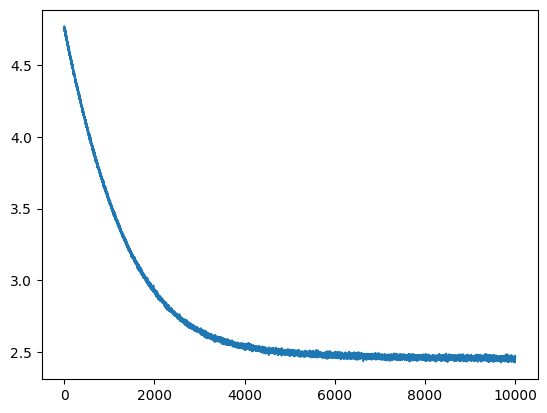

In [11]:
plt.plot(loss_list)
plt.show()

A sample generated by trained model

In [12]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300)
print("".join(decode(tokens[0]))) 


Ne wie kis he, ilouroonghl, e.
WairtD:

THAf&ICII' ayonghef n, OFoway!
m cacold thope?
Hin iench but daranc su ofyome orrepefrnd, iroo atomey bint s r sifllfo, t s chichakne fonokivay fino ay'ssathefomy wing3 ome setll.
GRD:
Hef br neerde lpedisst'l rd mer m
Nom; t hayou ten.
Fis s o d:
PAyouJUS:
To


## Learn by Attention

### Single head attention

#### Define model

In [13]:
from my_transformer import CausalSelfAttentionHead


class SimpleAttentionModel(nn.Module):
    def __init__(
        self, vocab_size: int, context_length: int, embed_size: int, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.char_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(context_length, embed_size)

        self.atten = CausalSelfAttentionHead(
            embed_size, 32, vocab_size, context_length, 0.01
        )

    def forward(self, x: torch.Tensor):
        char_embed = self.char_embed(x)  # (batch_size, context_length, embed_size)
        position_embed = self.position_embed(
            torch.arange(x.size(-1), device=device)
        )  # (context_length, embed_size)

        embed = char_embed + position_embed
        out = self.atten(embed)  # (batch_size, context_length, vocab_size)

        return out

#### Train

In [14]:
set_seed(1999)
model = SimpleAttentionModel(vocab_size, 64, 32).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

print(f"number of parameters of model is {num_parameters(model)}")
loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 32, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

number of parameters of model is 8385
loss at iteration 0 is 4.256787300109863
loss at iteration 1000 is 2.5861775875091553
loss at iteration 2000 is 2.4042856693267822
loss at iteration 3000 is 2.3411061763763428
loss at iteration 4000 is 2.3481667041778564
loss at iteration 5000 is 2.3282177448272705
loss at iteration 6000 is 2.315580129623413
loss at iteration 7000 is 2.309861421585083
loss at iteration 8000 is 2.332017660140991
loss at iteration 9000 is 2.2926015853881836
best loss achieved: 2.273582935333252


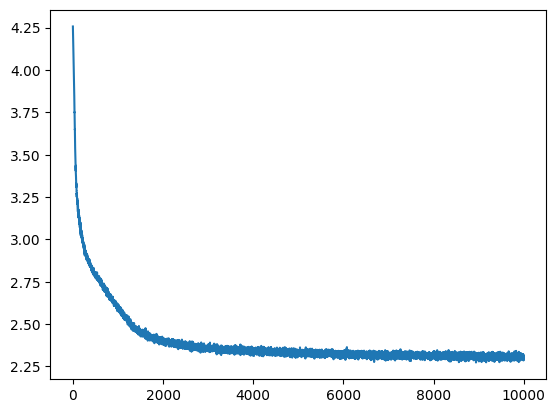

In [15]:
plt.plot(loss_list)
plt.show()

#### Example

In [16]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300, context_length=32)
print("".join(decode(tokens[0]))) 


BELTINO:
Fien ait are oupik:
Math havet tis hebaping ameig mme
Gol
Aves yoon:

When, hawto as bulllex yas, we go hes Wabot;
Kratli de
YOx fieprei fene.

DWhaim yoo oud mimeanerk, Vos.

CEDVO yu nquith ta'd wou grse, aver thack nourcenetalisbely len,
Is reeslery!
Matn.

UShis sougl ousce louset wome 


### Multi-head attention

#### Define Model

In [10]:
from my_transformer import MultiHeadAttention


class MultiHeadAttentionModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        context_length: int,
        embed_size: int,
        num_head: int,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.char_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(context_length, embed_size)

        self.mh_atten = MultiHeadAttention(
            input_size=embed_size,
            output_size=vocab_size,
            query_key_emb_size=32,
            value_emb_size=32,
            num_head=num_head,
            context_size=context_length,
            dropout_p=0.01,
        )

    def forward(self, x: torch.Tensor):
        char_embed = self.char_embed(x)  # (batch_size, context_length, embed_size)
        position_embed = self.position_embed(
            torch.arange(x.size(-1), device=device)
        )  # (context_length, embed_size)

        embed = char_embed + position_embed
        out = self.mh_atten(embed)  # (batch_size, context_length, vocab_size)

        return out

#### Train

In [11]:
set_seed(1999)
model = MultiHeadAttentionModel(vocab_size=vocab_size, context_length=64, embed_size=8, num_head=4).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

print(f"number of parameters of model is {num_parameters(model)}")
loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 32, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

number of parameters of model is 12873
loss at iteration 0 is 4.197534561157227
loss at iteration 1000 is 2.5518546104431152
loss at iteration 2000 is 2.3818299770355225
loss at iteration 3000 is 2.301259994506836
loss at iteration 4000 is 2.2323079109191895
loss at iteration 5000 is 2.2033004760742188
loss at iteration 6000 is 2.165595769882202
loss at iteration 7000 is 2.1524605751037598
loss at iteration 8000 is 2.152412176132202
loss at iteration 9000 is 2.1266870498657227
best loss achieved: 2.075582504272461


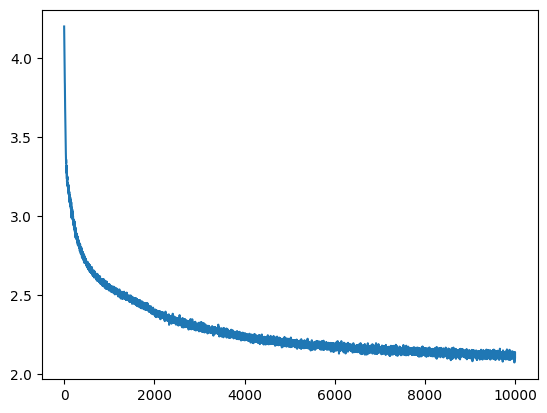

In [12]:
plt.plot(loss_list)
plt.show()

#### Example

In [13]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300, context_length=32)
print("".join(decode(tokens[0]))) 


To tes see yow male a Sace,
Norbeag toing aneme rout toulds Aspile.

DUETONTI's stus
Nis thinke inest ereee'd so owith andooon the is whill home, the of lare mote in so?

KINGLY:
Whit weereas Goou tock and de sompt cure.

ANTMNRO:
You thelends, of af nowh sangave have sus; to marde that:
Arond couf 


## Transformers

In [10]:
from my_transformer import MyTransformer


class SimpleGPT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        context_length: int,
        embed_size: int,
        num_layers: int,
        num_head: int,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.char_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(context_length, embed_size)

        self.transform = MyTransformer(
            input_size=embed_size,
            context_size=context_length,
            num_layers=num_layers,
            num_head=num_head,
            output_size=vocab_size,
            atten_kqv_size=2*embed_size,
            atten_output=embed_size,
            mlp_hidden_size=2*embed_size,
            activation=F.relu
        )

    def forward(self, x:torch.Tensor):
        char_emb = self.char_embed(x)
        pos_embed = self.position_embed(
            torch.arange(x.size(-1), device=device)
        )  # (context_length, embed_size)

        return self.transform(char_emb + pos_embed)
        

In [11]:
set_seed(1999)
model = SimpleGPT(vocab_size=vocab_size, context_length=64, embed_size=32, num_head=4, num_layers=4).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

print(f"number of parameters of model is {num_parameters(model)}")
loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 64, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

number of parameters of model is 157889
loss at iteration 0 is 4.358519077301025
loss at iteration 1000 is 1.967320203781128
loss at iteration 2000 is 1.687168836593628
loss at iteration 3000 is 1.6027016639709473
loss at iteration 4000 is 1.5406004190444946
loss at iteration 5000 is 1.5145882368087769
loss at iteration 6000 is 1.4820489883422852
loss at iteration 7000 is 1.4872647523880005
loss at iteration 8000 is 1.4700506925582886
loss at iteration 9000 is 1.453190803527832
best loss achieved: 1.4156805276870728


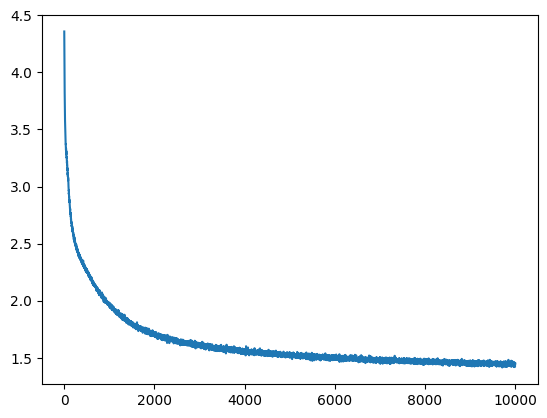

In [12]:
plt.plot(loss_list)
plt.show()

In [14]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300, context_length=32)
print("".join(decode(tokens[0]))) 


Master, which you will never you shall Marcius, hence; to sigh of the stob.

Second Lord Hastings.

KING RICHARD III:
Iurpita, and, so your uncle and made for Paulance; for for spilting like.

RIVERS OF
AUFIDIUS:
This sicurer eash of for that may shall here a wards her betitiend.

Provost:
I' this h
